In [136]:
Packages <- c("dplyr",  "nleqslv", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "stringr",  "lubridate", "RColorBrewer", "viridis")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
#source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/oceanography/scripts/LL_biophys.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R")
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/oceanography/scripts/format_genetic_parentage_matrix.R")
source("~/oceanography/scripts/format_genetic_kernel_parentage_matrix.R")
source("~/oceanography/scripts/format_biophys_normalized_matrix.R")
source("~/oceanography/scripts/format_biophys_parentage_matrix.R")
set.seed(7)
#source("~/oceanography/scripts/PredictedProportions.R")

#read in the kernel fitting summary
kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv")
kernel2012_14 <- fread(file="~/oceanography/empirical_data/genetics/GenKernelsForROMSComp2012-14.csv")

#read in the necessary input data for likelihood functions
load(file= "~/oceanography/script_output/SurveyData/for_likelihood_functions/2022-01-20_AddDestTables.Rdata")
load(file= "~/oceanography/script_output/ROMSDataTables/2021-11-04_SeededParticleInfo.Rdata")
load(file= "~/oceanography/script_output/SurveyData/for_likelihood_functions/2021-11-04_InputSurveyData.Rdata")



In [3]:
AllRecruitsGen <- fread("~/parentage/kernel_fitting/1340_loci/final_results/tables/AllFishObsWithPar.csv")
#head(AllRecruitsGen)
MonsoonRecSampPar <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitsByMonsoon2012-14ForROMSComp.csv")
#head(MonsoonRecSampPar)

#make one data table to rule them all....

AllRecruitsGenWithMonsoon <- left_join(AllRecruitsGen, MonsoonRecSampPar[, .(fish_indiv, year, monsoon=season)], by=c("fish_indiv", "year"))[
    offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][site %like% "Magbangon", site := "Magbangon"][year %in% c(2012, 2013, 2014)]

genetic_parentage_matrices <- suppressMessages(format_genetic_parentage_matrix(AllRecruitsGenWithMonsoon, SurveyData))
#fwrite(genetic_parentage_matrices$GenMat2012_4, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2012-14ForROMSComp.csv")
#fwrite(genetic_parentage_matrices$GenMat2012, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2012ForROMSComp.csv")
#fwrite(genetic_parentage_matrices$GenMat2013, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2013ForROMSComp.csv")
#fwrite(genetic_parentage_matrices$GenMat2014, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2014ForROMSComp.csv")
#fwrite(genetic_parentage_matrices$GenMatNEM, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrixNEM2012-14ForROMSComp.csv")
#fwrite(genetic_parentage_matrices$GenMatSWM, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrixSWM2012-14ForROMSComp.csv")


genetic_kernel_matrices <- suppressMessages(format_genetic_kernel_parentage_matrix(AllRecruitsGenWithMonsoon, SurveyData))

#fwrite(genetic_kernel_matrices$KernelGenMat2012_4, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2012-14ForROMSComp.csv")
#fwrite(genetic_kernel_matrices$KernelGenMat2012, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2012ForROMSComp.csv")
#fwrite(genetic_kernel_matrices$KernelGenMat2013, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2013ForROMSComp.csv")
#fwrite(genetic_kernel_matrices$KernelGenMat2014, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2014ForROMSComp.csv")
#fwrite(genetic_kernel_matrices$KernelGenMatNEM, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrixNEM2012-14ForROMSComp.csv")
#fwrite(genetic_kernel_matrices$KernelGenMatSWM, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrixSWM2012-14ForROMSComp.csv")


__read in the biophysical data and format for likelihood functions__

In [182]:
SimConn <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableCompleteMetaLongForm08DayPLD.csv")[year %in% c(2012, 2013, 2014) & dest != "CAI"][#filter out CAI as a destination for now, not very well spatially defined
   ,`:=`(daily_particles_rec=as.numeric(daily_particles_rec),daily_particles_released=as.numeric(daily_particles_released))][
    source == "Other" | source == "CAI", source:="unknown"][ #aggregate the CAI and other sites as "unknown for likelihood functions"
    , daily_particles_rec := sum(daily_particles_rec), by=c("date", "source", "dest")][
   , daily_particles_released :=sum(as.numeric(daily_particles_released)), by=c("date", "source")]
total_release_days
#read in already reformatted SimConn
#SimConn <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableCompleteMetaLongForm08DayPLDCorrectSeasonalReleaseDays.csv")

[1] 687

In [183]:
tail(SimConn)

particle_id,source,dest,year,monsoon,date,num_annual_parentage_matches,num_release_days_seasonal,num_release_days_annual,dest_num_females,...,source_num_rec_sampled_annual,source_prop_anem_samp,sim_month,sim_day,sim_year,daily_particles_rec,daily_particles_released,dist_km,bearing,direction
P212791324,Palanas,Caridad Cemetery,2014,NEM,2014-04-18,13,169,200,7,...,38,0.4468599,4,4,2014,8464,116064,5.692889,136.7402,136.7402
P212791325,Palanas,Caridad Cemetery,2014,NEM,2014-04-18,13,169,200,7,...,38,0.4468599,4,4,2014,8464,116064,5.692889,136.7402,136.7402
P212791326,Palanas,Caridad Cemetery,2014,NEM,2014-04-18,13,169,200,7,...,38,0.4468599,4,4,2014,8464,116064,5.692889,136.7402,136.7402
P212791327,Palanas,Caridad Cemetery,2014,NEM,2014-04-18,13,169,200,7,...,38,0.4468599,4,4,2014,8464,116064,5.692889,136.7402,136.7402
P212791328,Palanas,Caridad Cemetery,2014,NEM,2014-04-18,13,169,200,7,...,38,0.4468599,4,4,2014,8464,116064,5.692889,136.7402,136.7402
P212791329,Palanas,Sitio Baybayon,2014,NEM,2014-04-18,13,169,200,166,...,38,0.4468599,4,4,2014,1,116064,27.291943,165.0109,165.0109


In [191]:

biophys_norm_matrices <- format_biophys_normalized_matrix(SimConn=SimConn, total_release_days=687, AddDestSim=AddDestSim)
#fwrite(biophys_norm_matrices$FullBiophysMatNorm, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrix2012-14ForROMSComp08DayPLD.csv")
#fwrite(biophys_norm_matrices$AnnualBiophysMatNorm2012, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrix2012ForROMSComp08DayPLD.csv")
#fwrite(biophys_norm_matrices$AnnualBiophysMatNorm2013, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrix2013ForROMSComp08DayPLD.csv")
#fwrite(biophys_norm_matrices$AnnualBiophysMatNorm2014, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrix2014ForROMSComp08DayPLD.csv")
#fwrite(biophys_norm_matrices$MonsoonBiophysMatNormNEM, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrixNEMForROMSComp08DayPLD.csv" )
#fwrite(biophys_norm_matrices$MonsoonBiophysMatNormSWM, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysNormConnMatrixSWMForROMSComp08DayPLD.csv" )

biophys_parentage_matrices <- format_biophys_parentage_matrix(SimConn=SimConn, total_release_days=687, AddDestSim=AddDestSim)
#fwrite(biophys_parentage_matrices$FullBiophysMat, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrix2012-14ForROMSComp08DayPLD.csv")
#fwrite(biophys_parentage_matrices$AnnualBiophysMat2012, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrix2012ForROMSComp08DayPLD.csv")
#fwrite(biophys_parentage_matrices$AnnualBiophysMat2013, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrix2013ForROMSComp08DayPLD.csv")
#fwrite(biophys_parentage_matrices$AnnualBiophysMat2014, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrix2014ForROMSComp08DayPLD.csv")
fwrite(biophys_parentage_matrices$MonsoonBiophysMatNEM, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrixNEMForROMSComp08DayPLD.csv")
fwrite(biophys_parentage_matrices$MonsoonBiophysMatSWM, file="~/oceanography/script_output/ROMSDataTables/2022-01-20_BioPhysParentageMatrixSWMForROMSComp08DayPLD.csv")

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [193]:
sum(biophys_parentage_matrices$MonsoonBiophysMatNEM)+sum(biophys_parentage_matrices$MonsoonBiophysMatSWM)

[1] 955263

In [139]:
sum(biophys_parentage_matrices$AnnualBiophysMat2012)+sum(biophys_parentage_matrices$AnnualBiophysMat2013)+sum(biophys_parentage_matrices$AnnualBiophysMat2014)==sum(biophys_parentage_matrices$FullBiophysMat)
#should be true

[1] TRUE

In [140]:
nrow(SimConn)

[1] 955263

In [184]:
annual_rec_per_dest <- SimConn[,.(annual_rec_per_dest=.N), by=c("dest", "year")]#[, annual_particles_rec_dest:= sum(dail)])
sum(annual_rec_per_dest[,3])
monsoonal_rec_per_dest <- SimConn[,.(monsoonal_rec_per_dest= .N), by=c("dest", "monsoon")]#[, annual_particles_rec_dest:= sum(dail)])
sum(monsoonal_rec_per_dest[,3])
#make sure they both match

[1] 955263

[1] 955263

In [180]:
#SimConn[, `:=`(daily_particles_released=as.integer(daily_particles_released), daily_particles_rec=as.integer(daily_particles_rec))]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion to integer range”

In [181]:
head(SimConn)

particle_id,source,dest,year,monsoon,date,num_annual_parentage_matches,num_release_days_seasonal,num_release_days_annual,dest_num_females,...,sim_month,sim_day,sim_year,daily_particles_rec,daily_particles_released,dist_km,bearing,direction,annual_rec_per_dest,monsoonal_rec_per_dest
P54642131,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597
P54642132,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597
P54642133,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597
P54642134,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597
P54642135,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597
P54642136,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,NA,NA,NA,NA,8634,2597


In [185]:
SimConn <- left_join(SimConn, annual_rec_per_dest, by=c("dest", "year"))
SimConn <- left_join(SimConn, monsoonal_rec_per_dest, by=c("dest", "monsoon"))
head(SimConn)
nrow(SimConn)

particle_id,source,dest,year,monsoon,date,num_annual_parentage_matches,num_release_days_seasonal,num_release_days_annual,dest_num_females,...,sim_month,sim_day,sim_year,daily_particles_rec,daily_particles_released,dist_km,bearing,direction,annual_rec_per_dest,monsoonal_rec_per_dest
P54642131,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597
P54642132,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597
P54642133,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597
P54642134,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597
P54642135,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597
P54642136,unknown,Palanas,2012,SWM,2011-10-01,3,31,244,49,...,10,10,2011,4761,4254850688,NA,NA,NA,8634,2597


[1] 955263

In [186]:
str(SimConn)

Classes ‘data.table’ and 'data.frame':	955263 obs. of  25 variables:
 $ particle_id                  : chr  "P54642131" "P54642132" "P54642133" "P54642134" ...
 $ source                       : chr  "unknown" "unknown" "unknown" "unknown" ...
 $ dest                         : chr  "Palanas" "Palanas" "Palanas" "Palanas" ...
 $ year                         : int  2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 ...
 $ monsoon                      : chr  "SWM" "SWM" "SWM" "SWM" ...
 $ date                         : chr  "2011-10-01" "2011-10-01" "2011-10-01" "2011-10-01" ...
 $ num_annual_parentage_matches : int  3 3 3 3 3 3 3 3 3 3 ...
 $ num_release_days_seasonal    : int  31 31 31 31 31 31 31 31 31 31 ...
 $ num_release_days_annual      : int  244 244 244 244 244 244 244 244 244 244 ...
 $ dest_num_females             : int  49 49 49 49 49 49 49 49 49 49 ...
 $ dest_num_rec_sampled_annual  : int  13 13 13 13 13 13 13 13 13 13 ...
 $ dest_prop_samp               : num  0.29 0.29 0.29 

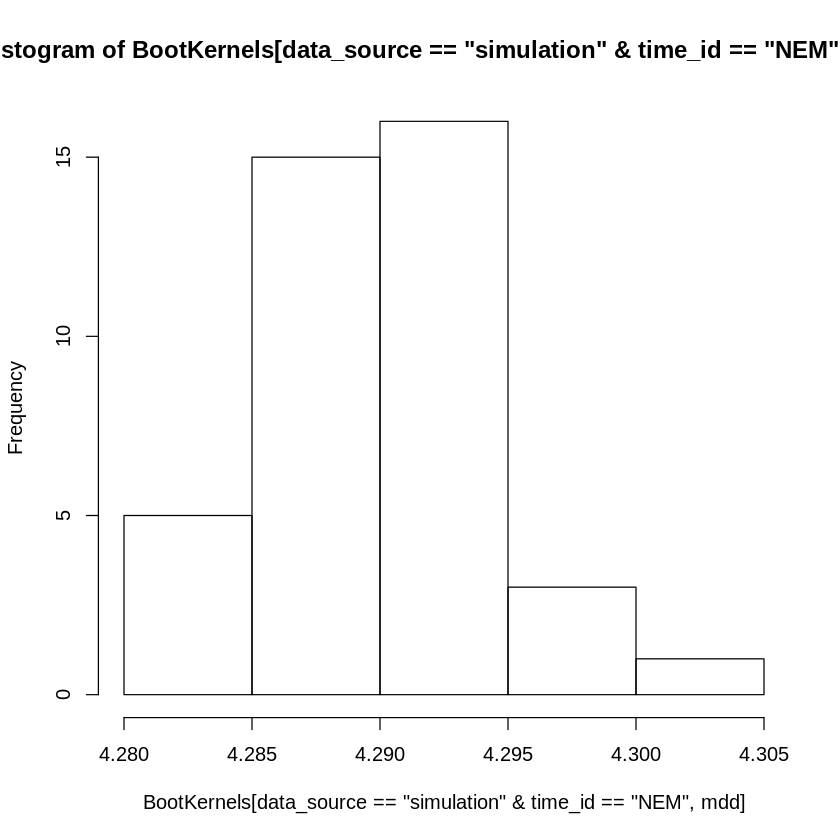

In [195]:
hist(BootKernels[data_source=="simulation" & time_id=="NEM", mdd])

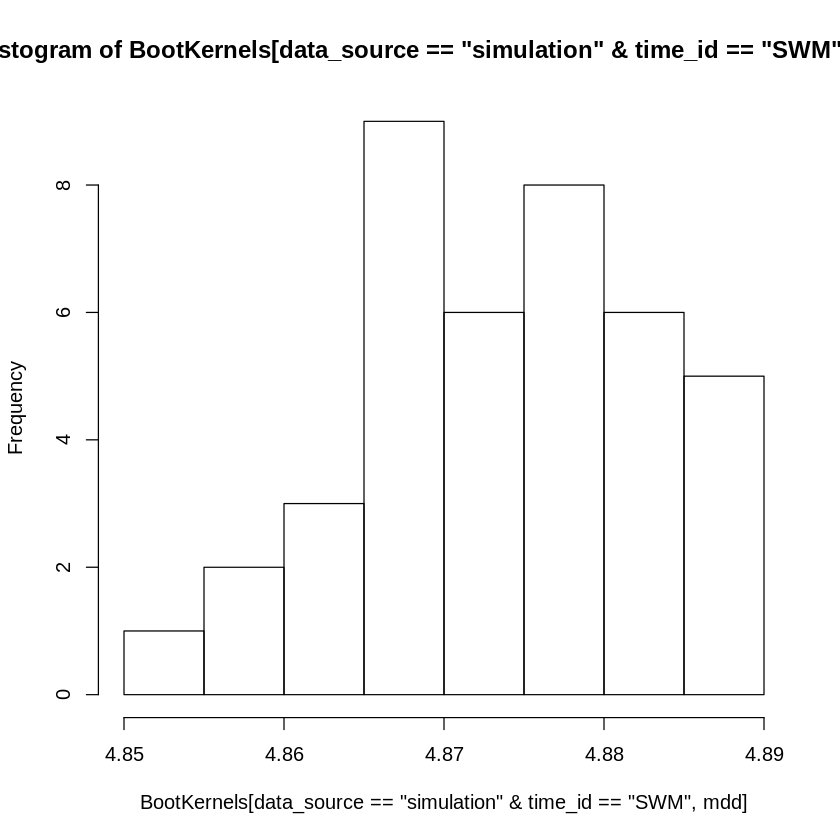

In [196]:
hist(BootKernels[data_source=="simulation" & time_id=="SWM", mdd])


In [210]:
sum(unique(SimConnInt2$annual_rec_per_dest,by=c("year", "dest")))

[1] 955263

# Get the best-fit kernels and profile likelihood confidence intervals in fit_data.ipynb


In [ ]:
sampled_reefs_vec <- as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]) #***I think these index values need to match dimensions of parentage matrix- filter out sand flats and other unsampled sites***
pop_size_vec <- as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]) #vector of pop sizes for all reefs (a). This term is also used in parentage kernel fitting, but reef sizes are substituted as a proxy for pop size. This is should be bootstrapped to account for uncertainty.
prop_samp_vec <- as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)])#vector of proportion of habitat sampled for all reefs in time period t- I think that I should be coming up with a different value for this, but for now this will help me code the function

#bootstrap the particle AND parentage data and re-fit kernels and perform bode likelihood function for dispersal event matching
num_samples_sim <- nrow(SimConn) #because each row in SimConn is a particle the number of rows is N samples per iteration for bootstrapping

#make table to hold results
BootKernels <- data.table(data_source=character(), time_scale=character(), time_id=character(), k=numeric(), theta=numeric(),num_matches=numeric(),num_recruits=numeric(), mdd=numeric(), med=numeric(), dist90=numeric(), log_like=numeric(), iteration=numeric())

BootLikelihood <- data.table(comparison=character(), time_scale=character(), data_source=character(), log_like=numeric(), iteration=numeric())

pb <- txtProgressBar(min = 0, max = 1000, style = 3)
AllRecruitsGen <- fread("~/parentage/kernel_fitting/1340_loci/final_results/tables/AllFishObsWithPar.csv")
MonsoonRecSampPar <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitsByMonsoon2012-14ForROMSComp.csv")


 AllRecruitsGenWithMonsoon <- left_join(AllRecruitsGen, MonsoonRecSampPar[, .(fish_indiv, year, monsoon=season)], by=c("fish_indiv", "year"))[
        offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][site %like% "Magbangon", site := "Magbangon"][year %in% c(2012, 2013, 2014)]    
 #    , .SD[sample(.N, 394, replace=TRUE)]] #resample the recruits with replacement not by the same number at each site

TotalOffsBySiteYear <- AllRecruitsGenWithMonsoon[, .(num_gen=.N), by=c("year", "site")]

AllRecruitsGenWithMonsoon2 <- left_join(AllRecruitsGenWithMonsoon, TotalOffsBySiteYear, by=c("year", "site"))

#######################################
##for kernels, use the matrices with NS magbangon seperated
#TotalOffsBySiteYear <- AllRecruitsGenWithMonsoon[, .(num_gen=.N), by=c("year", "site")]
#AllRecruitsGenWithMonsoon2 <- left_join(AllRecruitsGenWithMonsoon, TotalOffsBySiteYear, by=c("year", "site"))
#Centroids <- fread(file="~/oceanography/empirical_data/site_centroids_SimTest.csv") 
#Centroids$site <- gsub("_full", "", Centroids$site, fixed=TRUE)
#Centroids$site <- gsub("_ten_per_cover", "", Centroids$site, fixed=TRUE)
#
#Centroids <- Centroids %>%
#    arrange(site)
#### List of source locations
#SitesSource <- Centroids
#
#### List of destination locations
#SitesDest <- Centroids
#
#DistMatm <- distm(SitesSource[,c('lon','lat')], SitesSource[,c('lon','lat')], fun=distVincentyEllipsoid)
#Distances <- DistMatm*10^-3
#
#Area <- fread("~/oceanography/empirical_data/site_area_header_nonsurveyed_simulation_kernels_test.csv") %>%
#    arrange(site) %>%
#    filter(site %!in% c("near_north_full1", "near_north_full2", "near_north_full3", "near_south_full1", "near_south_full2", "near_south_full3")) %>%
#    mutate(kmsq=msq*10^-6)# %>%
#    #select(kmsq) #need to uncomment for functions to work
#Area$site <- gsub("_ten_per_cover", "", Area$site, fixed=TRUE)
#reef_sizes <- as.matrix(Area$kmsq)
#
#SiteIndex <- unique(Centroids %>% arrange(site), by="site")[, index := .I] #add the row number as the unique site index, leave CAI in if fitting a kernel SurveyData <- fread("~/oceanography/script_output/SurveyData/SurveyData.csv")
#######################################
for(i in 1:1000){
    
    #resample dispersal data, both genetics and simulation
    #SimConnInt2 <- SimConn[, .SD[sample(.N, num_samples_sim, replace=TRUE)]] #sample the particle data
    #test case resampling by site/year
    SimConnInt2 <- SimConn[, .SD[sample(.N, annual_rec_per_dest, replace=TRUE)], by=c("year", "dest")] #sample the particle data

    #subsampling the particle data
    SimConnInt2SubSample <- SimConn[!is.na(dest_num_rec_sampled_annual), .SD[sample(.N, dest_num_rec_sampled_annual, replace=TRUE)], by=c("year", "dest")] #subsample the particle data according to the number of recruits we sampled at each site
    
    SimConnInt2SubSamplePar <- SimConnInt2SubSample[!is.na(dest_num_rec_sampled_annual)& source !="unknown", .SD[sample(.N, num_annual_parentage_matches, replace=TRUE)], by="year"] #randomly assign parentage based on the number of matches from that year and use the source prop_samp as the probability weighting
    SimConnInt2SubSample[particle_id %!in% SimConnInt2SubSamplePar[, particle_id], source := "unknown"]#and then for every particle that we didn't assign as a match, label the source unknown so it goes in the unassigned row
    #nrow(SimConnInt2SubSample[source=="unknown"])+nrow(SimConnInt2SubSample[source!="unknown"]) #should equal 394onnInt2SubSample <- SimConn[!is.na(dest_num_rec_sampled_annual), .SD[sample(.N, dest_num_rec_sampled_annual, replace=TRUE)], by=c("year", "dest")] 

#make one data table to rule them all....

 #   AllRecruitsGenWithMonsoon <- left_join(AllRecruitsGen, MonsoonRecSampPar[, .(fish_indiv, year, monsoon=season)], by=c("fish_indiv", "year"))[
 #       offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][site %like% "Magbangon", site := "Magbangon"][year %in% c(2012, 2013, 2014)]    
 ##    , .SD[sample(.N, 394, replace=TRUE)]] #resample the recruits with replacement not by the same number at each site
 #  
    #TotalOffsBySiteYear <- AllRecruitsGenWithMonsoon[, .(num_gen=.N), by=c("year", "site")]
    
    #test case redoing with subsampling by site and year instead of total recruits sampled
    #AllRecruitsGenWithMonsoonInt <- AllRecruitsGenWithMonsoon2[, .SD[sample(.N, 394, replace=TRUE)]] #resample the recruits with replacement
    AllRecruitsGenWithMonsoonInt <- AllRecruitsGenWithMonsoon2[, .SD[sample(.N, num_gen, replace=TRUE)], by=c("year", "site")] #resample the recruits with replacement


    
        #format the matrices for kernel fitting and likelihood function
        genetic_parentage_matrices <- suppressMessages(format_genetic_parentage_matrix(AllRecruitsGenWithMonsoon=AllRecruitsGenWithMonsoonInt, SurveyData))
        genetic_kernel_matrices <- suppressMessages(format_genetic_kernel_parentage_matrix(AllRecruitsGenWithMonsoon=AllRecruitsGenWithMonsoonInt, SurveyData))
        
        biophys_norm_matrices <- format_biophys_normalized_matrix(SimConn=SimConnInt2, total_release_days=687, AddDestSim = AddDestSim)
        biophys_parentage_matrices <- format_biophys_parentage_matrix(SimConn=SimConnInt2, total_release_days=687, AddDestSim = AddDestSim)
        
        biophys_norm_matrices_subsample <- format_biophys_normalized_matrix(SimConn=SimConnInt2SubSample, total_release_days=687, AddDestSim = AddDestSim)
        biophys_parentage_matrices_subsample <- format_biophys_parentage_matrix(SimConn=SimConnInt2SubSample, total_release_days=687, AddDestSim = AddDestSim)



##fit the kernels
biophys_par_data2012 <- list(Distances=Distances, Assignments=biophys_parentage_matrices$AnnualBiophysMat2012, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$AnnualBiophysMat2012), .(index)])),
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$AnnualBiophysMat2012), ncol=1, 1))
Sim2012Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012, control=list(maxit=500)))

biophys_par_data2013 <- list(Distances=Distances, Assignments=biophys_parentage_matrices$AnnualBiophysMat2013, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$AnnualBiophysMat2013), .(index)])),
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$AnnualBiophysMat2013), ncol=1, 1))
Sim2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2013, control=list(maxit=500)))

biophys_par_data2014 <- list(Distances=Distances, Assignments=biophys_parentage_matrices$AnnualBiophysMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$AnnualBiophysMat2014), .(index)])),
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$AnnualBiophysMat2014), ncol=1, 1))
Sim2014Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2014, control=list(maxit=500)))

biophys_par_data2012_4 <- list(Distances=Distances, Assignments=biophys_parentage_matrices$FullBiophysMat, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$FullBiophysMat), .(index)])),
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$AnnualBiophysMat2014), ncol=1, 1))
Sim2012_4Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-.3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012_4, control=list(maxit=500)))

biophys_par_dataNEM <- list(Distances=Distances, Assignments=biophys_parentage_matrices$MonsoonBiophysMatNEM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$FullBiophysMat), .(index)])),
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$MonsoonBiophysMatNEM), ncol=1, 1))
SimNEMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataNEM, control=list(maxit=500)))

biophys_par_dataSWM <- list(Distances=Distances, Assignments=biophys_parentage_matrices$MonsoonBiophysMatSWM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% colnames(biophys_parentage_matrices$FullBiophysMat), .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(biophys_parentage_matrices$MonsoonBiophysMatSWM), ncol=1, 1))
SimSWMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=.6), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataSWM, control=list(maxit=500)))

#subsampled simulation data
biophys_par_data2012_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$AnnualBiophysMat2012, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2012 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2012 & prop_anem_samp >0, .(prop_anem_samp)]))
Sim2012Fit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012_subsample, control=list(maxit=500)))

biophys_par_data2013_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$AnnualBiophysMat2013, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2013 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2013 & prop_anem_samp >0, .(prop_anem_samp)]))
Sim2013Fit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2013_subsample, control=list(maxit=500)))

biophys_par_data2014_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$AnnualBiophysMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Sim2014Fit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2014_subsample, control=list(maxit=500)))

biophys_par_data2012_4_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$FullBiophysMat, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Sim2012_4Fit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012_4_subsample, control=list(maxit=500)))

biophys_par_dataNEM_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$MonsoonBiophysMatNEM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
SimNEMFit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataNEM_subsample, control=list(maxit=500)))

biophys_par_dataSWM_subsample <- list(Distances=Distances, Assignments=biophys_parentage_matrices_subsample$MonsoonBiophysMatSWM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
SimSWMFit_subsample <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataSWM_subsample, control=list(maxit=500)))

#genetic data with same reef metadata structure as model

par_data2012 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2012, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2012 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2012 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2012Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2012, control=list(maxit=500)))

par_data2013 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2013, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2013 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2013 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2013, control=list(maxit=500)))

par_data2014 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2014Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2014, control=list(maxit=500)))

par_data2012_4 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2012_4, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2012_4Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2012_4, control=list(maxit=500)))

par_dataNEM <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMatNEM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014  & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014   & prop_anem_samp >0, .(prop_anem_samp)]))
GenNEMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_dataNEM, control=list(maxit=500)))

par_dataSWM <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMatSWM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014  & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014   & prop_anem_samp >0, .(prop_anem_samp)]))
GenSWMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_dataSWM, control=list(maxit=500)))


#make a summary table for all time frames of simulation data
SimKernelsInt <- as.data.frame(matrix(NA, nrow = 12, ncol = 11))
setDT(SimKernelsInt)
setnames(SimKernelsInt, c("data_source", "time_scale", "time_id", "k", "theta","num_matches", "num_recruits", "mdd", "med", "dist90", "log_like"))


BestK2012 <- as.numeric(coef(Sim2012Fit)[1])
BestTheta2012 <- as.numeric(coef(Sim2012Fit)[2])
MDD2012 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012, theta=BestTheta2012, , method = "pcubature")$integral)
k_eval <- BestK2012
theta_eval <- BestTheta2012
Med2012  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[1] <- i
SimKernelsInt$data_source[1] <- "simulation"
SimKernelsInt$time_scale[1] <- "annual"
SimKernelsInt$time_id[1] <- "2012"
SimKernelsInt$k[1] <-  BestK2012
SimKernelsInt$theta[1] <- BestTheta2012
SimKernelsInt$num_matches[1] <-sum(biophys_par_data2012$Assignments[1:nrow(biophys_par_data2012$Assignments)-1,])
SimKernelsInt$num_recruits[1] <-sum(biophys_par_data2012$Assignments)
SimKernelsInt$mdd[1] <- MDD2012
SimKernelsInt$med[1] <- Med2012
SimKernelsInt$dist90[1] <- Dist90_2012
SimKernelsInt$log_like[1] <- logLik(Sim2012Fit)[1]

BestK2013 <- as.numeric(coef(Sim2013Fit)[1])
BestTheta2013 <- as.numeric(coef(Sim2013Fit)[2])
MDD2013 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2013, theta=BestTheta2013, , method = "pcubature")$integral)
k_eval <- BestK2013
theta_eval <- BestTheta2013
Med2013  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2013 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[2] <- i
SimKernelsInt$data_source[2] <- "simulation"
SimKernelsInt$time_scale[2] <- "annual"
SimKernelsInt$time_id[2] <- "2013"
SimKernelsInt$k[2] <-  BestK2013
SimKernelsInt$theta[2] <- BestTheta2013
SimKernelsInt$num_matches[2] <-sum(biophys_par_data2013$Assignments[1:nrow(biophys_par_data2013$Assignments)-1,])
SimKernelsInt$num_recruits[2] <-sum(biophys_par_data2013$Assignments)
SimKernelsInt$mdd[2] <- MDD2013
SimKernelsInt$med[2] <- Med2013
SimKernelsInt$dist90[2] <- Dist90_2013
SimKernelsInt$log_like[2] <- logLik(Sim2013Fit)[1]


BestK2014 <- as.numeric(coef(Sim2014Fit)[1])
BestTheta2014 <- as.numeric(coef(Sim2014Fit)[2])
MDD2014 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2014, theta=BestTheta2014, , method = "pcubature")$integral)
k_eval <- BestK2014
theta_eval <- BestTheta2014
Med2014  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2014 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[3] <- i
SimKernelsInt$data_source[3] <- "simulation"
SimKernelsInt$time_scale[3] <- "annual"
SimKernelsInt$time_id[3] <- "2014"
SimKernelsInt$k[3] <-  BestK2014
SimKernelsInt$theta[3] <- BestTheta2014
SimKernelsInt$num_matches[3] <-sum(biophys_par_data2014$Assignments[1:nrow(biophys_par_data2014$Assignments)-1,])
SimKernelsInt$num_recruits[3] <-sum(biophys_par_data2014$Assignments)
SimKernelsInt$mdd[3] <- MDD2014
SimKernelsInt$med[3] <- Med2014
SimKernelsInt$dist90[3] <- Dist90_2014
SimKernelsInt$log_like[3] <- logLik(Sim2014Fit)[1]

BestK2012_4 <- as.numeric(coef(Sim2012_4Fit)[1])
BestTheta2012_4 <- as.numeric(coef(Sim2012_4Fit)[2])
MDD2012_4 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012_4, theta=BestTheta2012_4, , method = "pcubature")$integral)
k_eval <- BestK2012_4
theta_eval <- BestTheta2012_4
Med2012_4  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012_4 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)
    
SimKernelsInt$iteration[4] <- i
SimKernelsInt$data_source[4] <- "simulation"
SimKernelsInt$time_scale[4] <- "total_years"
SimKernelsInt$time_id[4] <- "2012-4"
SimKernelsInt$k[4] <-  BestK2012_4
SimKernelsInt$theta[4] <- BestTheta2012_4
SimKernelsInt$num_matches[4] <-sum(biophys_par_data2012_4$Assignments[1:nrow(biophys_par_data2012_4$Assignments)-1,])
SimKernelsInt$num_recruits[4] <-sum(biophys_par_data2012_4$Assignments)
SimKernelsInt$mdd[4] <- MDD2012_4
SimKernelsInt$med[4] <- Med2012_4
SimKernelsInt$dist90[4] <- Dist90_2012_4
SimKernelsInt$log_like[4] <- logLik(Sim2012_4Fit)[1]

BestKNEM <- as.numeric(coef(SimNEMFit)[1])
BestThetaNEM <- as.numeric(coef(SimNEMFit)[2])
MDDNEM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKNEM, theta=BestThetaNEM, , method = "pcubature")$integral)
k_eval <- BestKNEM
theta_eval <- BestThetaNEM
MedNEM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[5] <- i
SimKernelsInt$data_source[5] <- "simulation"
SimKernelsInt$time_scale[5] <- "monsoonal"
SimKernelsInt$time_id[5] <- "NEM"
SimKernelsInt$k[5] <-  BestKNEM
SimKernelsInt$theta[5] <- BestThetaNEM
SimKernelsInt$num_matches[5] <-sum(biophys_par_dataNEM$Assignments[1:nrow(biophys_par_dataNEM$Assignments)-1,])
SimKernelsInt$num_recruits[5] <-sum(biophys_par_dataNEM$Assignments)
SimKernelsInt$mdd[5] <- MDDNEM
SimKernelsInt$med[5] <- MedNEM
SimKernelsInt$dist90[5] <- Dist90_NEM
SimKernelsInt$log_like[5] <- logLik(SimNEMFit)[1]

BestKSWM <- as.numeric(coef(SimSWMFit)[1])
BestThetaSWM <- as.numeric(coef(SimSWMFit)[2])
MDDSWM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKSWM, theta=BestThetaSWM, , method = "pcubature")$integral)
k_eval <- BestKSWM
theta_eval <- BestThetaSWM
MedSWM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[6] <- i
SimKernelsInt$data_source[6] <- "simulation"
SimKernelsInt$time_scale[6] <- "monsoonal"
SimKernelsInt$time_id[6] <- "SWM"
SimKernelsInt$k[6] <-  BestKSWM
SimKernelsInt$theta[6] <- BestThetaSWM
SimKernelsInt$num_matches[6] <-sum(biophys_par_dataSWM$Assignments[1:nrow(biophys_par_dataSWM$Assignments)-1,])
SimKernelsInt$num_recruits[6] <-sum(biophys_par_dataSWM$Assignments)
SimKernelsInt$mdd[6] <- MDDSWM
SimKernelsInt$med[6] <- MedSWM
SimKernelsInt$dist90[6] <- Dist90_SWM
SimKernelsInt$log_like[6] <- logLik(SimSWMFit)[1]

#add the subsampled results
    
BestK2012 <- as.numeric(coef(Sim2012Fit_subsample)[1])
BestTheta2012 <- as.numeric(coef(Sim2012Fit_subsample)[2])
MDD2012 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012, theta=BestTheta2012, , method = "pcubature")$integral)
k_eval <- BestK2012
theta_eval <- BestTheta2012
Med2012  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[7] <- i
SimKernelsInt$data_source[7] <- "simulation_subsample"
SimKernelsInt$time_scale[7] <- "annual"
SimKernelsInt$time_id[7] <- "2012"
SimKernelsInt$k[7] <-  BestK2012
SimKernelsInt$theta[7] <- BestTheta2012
SimKernelsInt$num_matches[7] <-sum(biophys_par_data2012_subsample$Assignments[1:nrow(biophys_par_data2012_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[7] <-sum(biophys_par_data2012_subsample$Assignments)
SimKernelsInt$mdd[7] <- MDD2012
SimKernelsInt$med[7] <- Med2012
SimKernelsInt$dist90[7] <- Dist90_2012
SimKernelsInt$log_like[7] <- logLik(Sim2012Fit_subsample)[1]

BestK2013 <- as.numeric(coef(Sim2013Fit_subsample)[1])
BestTheta2013 <- as.numeric(coef(Sim2013Fit_subsample)[2])
MDD2013 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2013, theta=BestTheta2013, , method = "pcubature")$integral)
k_eval <- BestK2013
theta_eval <- BestTheta2013
Med2013  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2013 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[8] <- i
SimKernelsInt$data_source[8] <- "simulation_subsample"
SimKernelsInt$time_scale[8] <- "annual"
SimKernelsInt$time_id[8] <- "2013"
SimKernelsInt$k[8] <-  BestK2013
SimKernelsInt$theta[8] <- BestTheta2013
SimKernelsInt$num_matches[8] <-sum(biophys_par_data2013_subsample$Assignments[1:nrow(biophys_par_data2013_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[8] <-sum(biophys_par_data2013_subsample$Assignments)
SimKernelsInt$mdd[8] <- MDD2013
SimKernelsInt$med[8] <- Med2013
SimKernelsInt$dist90[8] <- Dist90_2013
SimKernelsInt$log_like[8] <- logLik(Sim2013Fit_subsample)[1]


BestK2014 <- as.numeric(coef(Sim2014Fit_subsample)[1])
BestTheta2014 <- as.numeric(coef(Sim2014Fit_subsample)[2])
MDD2014 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2014, theta=BestTheta2014, , method = "pcubature")$integral)
k_eval <- BestK2014
theta_eval <- BestTheta2014
Med2014  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2014 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[9] <- i
SimKernelsInt$data_source[9] <- "simulation_subsample"
SimKernelsInt$time_scale[9] <- "annual"
SimKernelsInt$time_id[9] <- "2014"
SimKernelsInt$k[9] <-  BestK2014
SimKernelsInt$theta[9] <- BestTheta2014
SimKernelsInt$num_matches[9] <-sum(biophys_par_data2014_subsample$Assignments[1:nrow(biophys_par_data2014_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[9] <-sum(biophys_par_data2014_subsample$Assignments)
SimKernelsInt$mdd[9] <- MDD2014
SimKernelsInt$med[9] <- Med2014
SimKernelsInt$dist90[9] <- Dist90_2014
SimKernelsInt$log_like[9] <- logLik(Sim2014Fit_subsample)[1]

BestK2012_4 <- as.numeric(coef(Sim2012_4Fit_subsample)[1])
BestTheta2012_4 <- as.numeric(coef(Sim2012_4Fit_subsample)[2])
MDD2012_4 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012_4, theta=BestTheta2012_4, , method = "pcubature")$integral)
k_eval <- BestK2012_4
theta_eval <- BestTheta2012_4
Med2012_4  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012_4 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)
    
SimKernelsInt$iteration[10] <- i
SimKernelsInt$data_source[10] <- "simulation_subsample"
SimKernelsInt$time_scale[10] <- "total_years"
SimKernelsInt$time_id[10] <- "2012-4"
SimKernelsInt$k[10] <-  BestK2012_4
SimKernelsInt$theta[10] <- BestTheta2012_4
SimKernelsInt$num_matches[10] <-sum(biophys_par_data2012_4_subsample$Assignments[1:nrow(biophys_par_data2012_4_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[10] <-sum(biophys_par_data2012_4_subsample$Assignments)
SimKernelsInt$mdd[10] <- MDD2012_4
SimKernelsInt$med[10] <- Med2012_4
SimKernelsInt$dist90[10] <- Dist90_2012_4
SimKernelsInt$log_like[10] <- logLik(Sim2012_4Fit_subsample)[1]

BestKNEM <- as.numeric(coef(SimNEMFit_subsample)[1])
BestThetaNEM <- as.numeric(coef(SimNEMFit_subsample)[2])
MDDNEM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKNEM, theta=BestThetaNEM, , method = "pcubature")$integral)
k_eval <- BestKNEM
theta_eval <- BestThetaNEM
MedNEM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[11] <- i
SimKernelsInt$data_source[11] <- "simulation_subsample"
SimKernelsInt$time_scale[11] <- "monsoonal"
SimKernelsInt$time_id[11] <- "NEM"
SimKernelsInt$k[11] <-  BestKNEM
SimKernelsInt$theta[11] <- BestThetaNEM
SimKernelsInt$num_matches[11] <-sum(biophys_par_dataNEM_subsample$Assignments[1:nrow(biophys_par_dataNEM_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[11] <-sum(biophys_par_dataNEM_subsample$Assignments)
SimKernelsInt$mdd[11] <- MDDNEM
SimKernelsInt$med[11] <- MedNEM
SimKernelsInt$dist90[11] <- Dist90_NEM
SimKernelsInt$log_like[11] <- logLik(SimNEMFit_subsample)[1]

BestKSWM <- as.numeric(coef(SimSWMFit_subsample)[1])
BestThetaSWM <- as.numeric(coef(SimSWMFit_subsample)[2])
MDDSWM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKSWM, theta=BestThetaSWM, , method = "pcubature")$integral)
k_eval <- BestKSWM
theta_eval <- BestThetaSWM
MedSWM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

SimKernelsInt$iteration[12] <- i
SimKernelsInt$data_source[12] <- "simulation_subsample"
SimKernelsInt$time_scale[12] <- "monsoonal"
SimKernelsInt$time_id[12] <- "SWM"
SimKernelsInt$k[12] <-  BestKSWM
SimKernelsInt$theta[12] <- BestThetaSWM
SimKernelsInt$num_matches[12] <-sum(biophys_par_dataSWM_subsample$Assignments[1:nrow(biophys_par_dataSWM_subsample$Assignments)-1,])
SimKernelsInt$num_recruits[12] <-sum(biophys_par_dataSWM_subsample$Assignments)
SimKernelsInt$mdd[12] <- MDDSWM
SimKernelsInt$med[12] <- MedSWM
SimKernelsInt$dist90[12] <- Dist90_SWM
SimKernelsInt$log_like[12] <- logLik(SimSWMFit_subsample)[1]

    
#make a summary table for all time frames of genetic data
GenKernelsInt <- as.data.frame(matrix(NA, nrow = 6, ncol = 11))
setDT(GenKernelsInt)
setnames(GenKernelsInt, c("data_source", "time_scale", "time_id", "k", "theta", "num_matches", "num_recruits", "mdd", "med", "dist90", "log_like"))
#GenKernelsInt <- data.table(data_source=time_scale=character(), time_id=character(), k=numeric(), theta=numeric(), mdd=numeric(), med=numeric(), dist90=numeric())


BestK2012 <- as.numeric(coef(Gen2012Fit)[1])
BestTheta2012 <- as.numeric(coef(Gen2012Fit)[2])
MDD2012 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012, theta=BestTheta2012, , method = "pcubature")$integral)
k_eval <- BestK2012
theta_eval <- BestTheta2012
Med2012  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[1] <- i
GenKernelsInt$data_source[1] <- "genetics"    
GenKernelsInt$time_scale[1] <- "annual"
GenKernelsInt$time_id[1] <- "2012"
GenKernelsInt$k[1] <-  BestK2012
GenKernelsInt$theta[1] <- BestTheta2012
GenKernelsInt$num_matches[1] <-sum(par_data2012$Assignments[1:nrow(par_data2012$Assignments)-1,])
GenKernelsInt$num_recruits[1] <-sum(par_data2012$Assignments)
GenKernelsInt$mdd[1] <- MDD2012
GenKernelsInt$med[1] <- Med2012
GenKernelsInt$dist90[1] <- Dist90_2012
GenKernelsInt$log_like[1] <- logLik(Gen2012Fit)[1]

BestK2013 <- as.numeric(coef(Gen2013Fit)[1])
BestTheta2013 <- as.numeric(coef(Gen2013Fit)[2])
MDD2013 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2013, theta=BestTheta2013, , method = "pcubature")$integral)
k_eval <- BestK2013
theta_eval <- BestTheta2013
Med2013  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2013 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[2] <- i
GenKernelsInt$data_source[2] <- "genetics"    
GenKernelsInt$time_scale[2] <- "annual"
GenKernelsInt$time_id[2] <- "2013"
GenKernelsInt$k[2] <-  BestK2013
GenKernelsInt$theta[2] <- BestTheta2013
GenKernelsInt$num_matches[2] <-sum(par_data2013$Assignments[1:nrow(par_data2013$Assignments)-1,])
GenKernelsInt$num_recruits[2] <-sum(par_data2013$Assignments)
GenKernelsInt$mdd[2] <- MDD2013
GenKernelsInt$med[2] <- Med2013
GenKernelsInt$dist90[2] <- Dist90_2013
GenKernelsInt$log_like[2] <- logLik(Gen2013Fit)[1]

BestK2014 <- as.numeric(coef(Gen2014Fit)[1])
BestTheta2014 <- as.numeric(coef(Gen2014Fit)[2])
MDD2014 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2014, theta=BestTheta2014, , method = "pcubature")$integral)
k_eval <- BestK2014
theta_eval <- BestTheta2014
Med2014  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2014 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[3] <- i
GenKernelsInt$data_source[3] <- "genetics"    
GenKernelsInt$time_scale[3] <- "annual"
GenKernelsInt$time_id[3] <- "2014"
GenKernelsInt$k[3] <-  BestK2014
GenKernelsInt$theta[3] <- BestTheta2014
GenKernelsInt$num_matches[3] <-sum(par_data2014$Assignments[1:nrow(par_data2014$Assignments)-1,])
GenKernelsInt$num_recruits[3] <-sum(par_data2014$Assignments)
GenKernelsInt$mdd[3] <- MDD2014
GenKernelsInt$med[3] <- Med2014
GenKernelsInt$dist90[3] <- Dist90_2014
GenKernelsInt$log_like[3] <- logLik(Gen2014Fit)[1]

BestK2012_4 <- as.numeric(coef(Gen2012_4Fit)[1])
BestTheta2012_4 <- as.numeric(coef(Gen2012_4Fit)[2])
MDD2012_4 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012_4, theta=BestTheta2012_4, , method = "pcubature")$integral)
k_eval <- BestK2012_4
theta_eval <- BestTheta2012_4
Med2012_4  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_2012_4 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[4] <- i
GenKernelsInt$data_source[4] <- "genetics"    
GenKernelsInt$time_scale[4] <- "total_years"
GenKernelsInt$time_id[4] <- "2012-4"
GenKernelsInt$k[4] <-  BestK2012_4
GenKernelsInt$theta[4] <- BestTheta2012_4
GenKernelsInt$num_matches[4] <-sum(par_data2012_4$Assignments[1:nrow(par_data2012_4$Assignments)-1,])
GenKernelsInt$num_recruits[4] <-sum(par_data2012_4$Assignments)
GenKernelsInt$mdd[4] <- MDD2012_4
GenKernelsInt$med[4] <- Med2012_4
GenKernelsInt$dist90[4] <- Dist90_2012_4
GenKernelsInt$log_like[4] <- logLik(Gen2012_4Fit)[1]

BestKNEM <- as.numeric(coef(GenNEMFit)[1])
BestThetaNEM <- as.numeric(coef(GenNEMFit)[2])
MDDNEM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKNEM, theta=BestThetaNEM, , method = "pcubature")$integral)
k_eval <- BestKNEM
theta_eval <- BestThetaNEM
MedNEM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[5] <- i
GenKernelsInt$data_source[5] <- "genetics"    
GenKernelsInt$time_scale[5] <- "monsoonal"
GenKernelsInt$time_id[5] <- "NEM"
GenKernelsInt$k[5] <-  BestKNEM
GenKernelsInt$theta[5] <- BestThetaNEM
GenKernelsInt$num_matches[5] <-sum(par_dataNEM$Assignments[1:nrow(par_dataNEM$Assignments)-1,])
GenKernelsInt$num_recruits[5] <-sum(par_dataNEM$Assignments)
GenKernelsInt$mdd[5] <- MDDNEM
GenKernelsInt$med[5] <- MedNEM
GenKernelsInt$dist90[5] <- Dist90_NEM
GenKernelsInt$log_like[5] <- logLik(GenNEMFit)[1]

BestKSWM <- as.numeric(coef(GenSWMFit)[1])
BestThetaSWM <- as.numeric(coef(GenSWMFit)[2])
MDDSWM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKSWM, theta=BestThetaSWM, , method = "pcubature")$integral)
k_eval <- BestKSWM
theta_eval <- BestThetaSWM
MedSWM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 4) 
Dist90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 4)

GenKernelsInt$iteration[6] <- i
GenKernelsInt$data_source[6] <- "genetics"    
GenKernelsInt$time_scale[6] <- "monsoonal"
GenKernelsInt$time_id[6] <- "SWM"
GenKernelsInt$k[6] <-  BestKSWM
GenKernelsInt$theta[6] <- BestThetaSWM
GenKernelsInt$num_matches[6] <-sum(par_dataSWM$Assignments[1:nrow(par_dataSWM$Assignments)-1,])
GenKernelsInt$num_recruits[6] <-sum(par_dataSWM$Assignments)
GenKernelsInt$mdd[6] <- MDDSWM
GenKernelsInt$med[6] <- MedSWM
GenKernelsInt$dist90[6] <- Dist90_SWM
GenKernelsInt$log_like[6] <- logLik(GenSWMFit)[1]

GenKernelsInt$iteration <- i
GenKernelsInt$data_source <- "genetics"

        BootKernelsInt <- rbind(SimKernelsInt, GenKernelsInt)
   
        BootKernels <- rbind(BootKernels, BootKernelsInt)
    
 #also bootstrap the biophysical likelihood
Data_par2012_bio2012 <- list(BioPhysMat=as.matrix(biophys_norm_matrices$AnnualBiophysMatNorm2012[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012[1:nrow(genetic_parentage_matrices$GenMat2012)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2012,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012[nrow(genetic_parentage_matrices$GenMat2012),]))

Data_par2013_bio2013 <- list(BioPhysMat=as.matrix(biophys_norm_matrices$AnnualBiophysMatNorm2013[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2013[1:nrow(genetic_parentage_matrices$GenMat2013)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2013,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2013[nrow(genetic_parentage_matrices$GenMat2013),]))

Data_par2014_bio2014 <- list(BioPhysMat=as.matrix(biophys_norm_matrices$AnnualBiophysMatNorm2014[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2014[1:nrow(genetic_parentage_matrices$GenMat2014)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2014[nrow(genetic_parentage_matrices$GenMat2014),]))


#total compared to total
Data_par2012_4_bio2012_4 <- list(BioPhysMat=as.matrix(biophys_norm_matrices$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012_4[1:nrow(genetic_parentage_matrices$GenMat2012_4)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012_4[nrow(genetic_parentage_matrices$GenMat2012_4),]))

#for seasonal kernels

 Data_parNEM_bioNEM <- list(BioPhysMat=as.matrix(biophys_norm_matrices$MonsoonBiophysMatNormNEM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),]))

 Data_parSWM_bioSWM <- list(BioPhysMat=as.matrix(biophys_norm_matrices$MonsoonBiophysMatNormSWM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))
#total to total 
 Data_parNEMSWM_bio2012_4 <- list(BioPhysMat=as.matrix(biophys_norm_matrices$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=(as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,])+
                                  as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,])), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),])+
                    as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))

#calculate likelihood
LL_annual_annual <- LL_biophys(Data_par2012_bio2012)+LL_biophys(Data_par2013_bio2013)+LL_biophys(Data_par2014_bio2014)
LL_total_total <- LL_biophys(Data_par2012_4_bio2012_4)
LL_monsoonal_monsoonal <- LL_biophys(Data_parNEM_bioNEM)+LL_biophys(Data_parSWM_bioSWM)
LL_monsoonal_total <- LL_biophys(Data_parNEMSWM_bio2012_4)

#subsampled simulation data
Data_par2012_bio2012_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2012[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012[1:nrow(genetic_parentage_matrices$GenMat2012)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2012,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012[nrow(genetic_parentage_matrices$GenMat2012),]))

Data_par2013_bio2013_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2013[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2013[1:nrow(genetic_parentage_matrices$GenMat2013)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2013,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2013[nrow(genetic_parentage_matrices$GenMat2013),]))

Data_par2014_bio2014_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2014[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2014[1:nrow(genetic_parentage_matrices$GenMat2014)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2014[nrow(genetic_parentage_matrices$GenMat2014),]))


#total compared to total
Data_par2012_4_bio2012_4_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012_4[1:nrow(genetic_parentage_matrices$GenMat2012_4)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012_4[nrow(genetic_parentage_matrices$GenMat2012_4),]))

#for seasonal kernels

 Data_parNEM_bioNEM_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$MonsoonBiophysMatNormNEM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),]))

 Data_parSWM_bioSWM_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$MonsoonBiophysMatNormSWM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))
#total to total 
 Data_parNEMSWM_bio2012_4_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=(as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,])+
                                  as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,])), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),])+
                    as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))

#calculate likelihood
LL_annual_annual_subsample <- LL_biophys(Data_par2012_bio2012_subsample)+LL_biophys(Data_par2013_bio2013_subsample)+LL_biophys(Data_par2014_bio2014_subsample)
LL_total_total_subsample <- LL_biophys(Data_par2012_4_bio2012_4_subsample)
LL_monsoonal_monsoonal_subsample <- LL_biophys(Data_parNEM_bioNEM_subsample)+LL_biophys(Data_parSWM_bioSWM_subsample)
LL_monsoonal_total_subsample <- LL_biophys(Data_parNEMSWM_bio2012_4_subsample)
    
#store results
LLInt <- data.table(comparison= c("gen_total_bio_total", "gen_annual_bio_annual", "gen_monsoonal_bio_monsoonal", "gen_monsoonal_bio_total", "gen_total_bio_total", "gen_annual_bio_annual", "gen_monsoonal_bio_monsoonal", "gen_monsoonal_bio_total"), 
           time_scale= c("total_years", "annual", "total_monsoons", "monsoonal"),
           log_like=c(LL_total_total, LL_annual_annual, LL_monsoonal_monsoonal, LL_monsoonal_total, LL_total_total_subsample, LL_annual_annual_subsample, LL_monsoonal_monsoonal_subsample, LL_monsoonal_total_subsample), 
            data_source = c("simulation","simulation","simulation","simulation", "simulation_subsample", "simulation_subsample","simulation_subsample","simulation_subsample"))
LLInt$iteration <- i
    
BootLikelihood <- rbind(BootLikelihood, LLInt)
    
setTxtProgressBar(pb, i)
    }
close(pb)

fwrite(BootKernels, "~/oceanography/script_output/KernelFits/BootstrappedBiophysicalKernels08DayPLD-2022-03-22.csv")
fwrite(BootLikelihood, "~/oceanography/script_output/KernelFits/BootstrappedBiophysicalLikelihoods08DayPLD-2022-03-22.csv")

  |===============================                                       |  44%

In [220]:
BootLikelihood

comparison,time_scale,data_source,log_like,iteration
gen_total_bio_total,total_years,simulation,-44660.548,1
gen_annual_bio_annual,annual,simulation,-43474.796,1
gen_monsoonal_bio_monsoonal,total_monsoons,simulation,-13434.621,1
gen_monsoonal_bio_total,monsoonal,simulation,-30739.449,1
gen_total_bio_total,total_years,simulation_subsample,-13268.043,1
gen_annual_bio_annual,annual,simulation_subsample,-6621.411,1
gen_monsoonal_bio_monsoonal,total_monsoons,simulation_subsample,-1565.319,1
gen_monsoonal_bio_total,monsoonal,simulation_subsample,-8421.347,1
gen_total_bio_total,total_years,simulation,-44447.305,2
gen_annual_bio_annual,annual,simulation,-41907.217,2


In [216]:
(biophys_par_dataNEM$Assignments)
(biophys_par_dataSWM$Assignments)

Cabatoan,Caridad Cemetery,Caridad Proper,Elementary School,Gabas,Haina,Hicgop South,Magbangon,Palanas,Poroc Rose,Poroc San Flower,San Agustin,Sitio Baybayon,Sitio Lonas,Sitio Tugas,Tamakin Dacot,Visca,Wangag
978,1185,1748,245,0,50,903,752,198,62,149,424,878,364,347,49,1,264
716,2187,2866,219,8,15,189,723,131,66,140,535,884,654,314,0,0,133
812,750,1999,186,0,12,206,526,58,56,200,691,702,677,327,1,0,83
426,913,1570,1628,0,37,3740,417,100,169,299,815,524,704,1753,7,1,89
122,85,304,1684,15200,160,1182,102,30,440,990,4611,172,9454,1539,85,7788,16
16,0,7,152,19,3274,33,9,3,22,40,55,16,27,46,824,52,6
987,2141,3360,1974,59,476,3773,753,209,740,1058,1803,1794,2127,1712,270,74,388
744,1853,2796,194,0,49,831,463,347,47,86,528,1479,280,241,36,12,532
642,1504,767,3,0,0,68,740,628,7,4,31,3122,2,62,0,0,569
42,283,695,920,13,162,693,11,82,689,1002,1969,96,4403,987,99,682,50


Cabatoan,Caridad Cemetery,Caridad Proper,Elementary School,Gabas,Haina,Hicgop South,Magbangon,Palanas,Poroc Rose,Poroc San Flower,San Agustin,Sitio Baybayon,Sitio Lonas,Sitio Tugas,Tamakin Dacot,Visca,Wangag
12,0,0,0,0,0,0,5,30,0,0,0,56,0,0,0,0,5
24,41,77,0,0,0,44,12,3,0,0,0,41,0,0,0,0,3
18,17,123,0,0,0,44,9,2,0,0,0,43,0,0,0,0,10
19,21,205,0,0,0,130,3,1,0,0,0,9,0,70,0,0,6
2,0,63,86,1790,13,18,2,2,346,282,902,0,1238,21,33,858,0
3,0,3,0,0,237,0,1,0,0,0,46,45,0,6,507,24,5
43,43,209,0,0,0,392,16,2,0,0,0,45,0,0,0,0,9
10,0,19,0,0,0,1,16,11,0,0,0,126,0,0,0,0,22
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95,21,333,79,0,0,14,11,0,48,116,310,36,618,38,0,6,1


In [157]:
cv <- function(x){
    sd(x)/mean(x)
}

BootBioPhysCV <- BootKernels[time_scale != "total_years" & num_matches>0 ,.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3)), by=c("time_scale","data_source", "iteration")] #, sd_kurtosis=round(sd(kurtosis), 2) 

In [159]:
summary(BootBioPhysCV[data_source=="simulation"])

  time_scale        data_source          iteration      cv_theta      
 Length:4           Length:4           Min.   :1.0   Min.   :0.05800  
 Class :character   Class :character   1st Qu.:1.0   1st Qu.:0.05800  
 Mode  :character   Mode  :character   Median :1.5   Median :0.08650  
                                       Mean   :1.5   Mean   :0.08725  
                                       3rd Qu.:2.0   3rd Qu.:0.11575  
                                       Max.   :2.0   Max.   :0.11800  
     cv_mdd       
 Min.   :0.04900  
 1st Qu.:0.04975  
 Median :0.07000  
 Mean   :0.07025  
 3rd Qu.:0.09050  
 Max.   :0.09200  

In [ ]:
#subsampled simulation data
Data_par2012_bio2012_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2012[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012[1:nrow(genetic_parentage_matrices$GenMat2012)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2012,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012[nrow(genetic_parentage_matrices$GenMat2012),]))

Data_par2013_bio2013_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2013[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2013[1:nrow(genetic_parentage_matrices$GenMat2013)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2013,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2013[nrow(genetic_parentage_matrices$GenMat2013),]))

Data_par2014_bio2014_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$AnnualBiophysMatNorm2014[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2014[1:nrow(genetic_parentage_matrices$GenMat2014)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2014[nrow(genetic_parentage_matrices$GenMat2014),]))


#total compared to total
Data_par2012_4_bio2012_4_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=genetic_parentage_matrices$GenMat2012_4[1:nrow(genetic_parentage_matrices$GenMat2012_4)-1,], 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMat2012_4[nrow(genetic_parentage_matrices$GenMat2012_4),]))

#for seasonal kernels

 Data_parNEM_bioNEM_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$MonsoonBiophysMatNormNEM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),]))

 Data_parSWM_bioSWM_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$MonsoonBiophysMatNormSWM[1:nrow(sampled_reefs_vec),]),
                    Assignments=as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,]), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))
#total to total 
 Data_parNEMSWM_bio2012_4_subsample <- list(BioPhysMat=as.matrix(biophys_norm_matrices_subsample$FullBiophysMatNorm[1:nrow(sampled_reefs_vec),]),
                    Assignments=(as.matrix(genetic_parentage_matrices$GenMatNEM[1:nrow(genetic_parentage_matrices$GenMatNEM)-1,])+
                                  as.matrix(genetic_parentage_matrices$GenMatSWM[1:nrow(genetic_parentage_matrices$GenMatSWM)-1,])), 
                   pop_size_vec=as.matrix(SurveyData[,.(avg_num_females=mean(num_females, na.rm = TRUE)), by=site][order(site)][, .(avg_num_females)]), 
                   sampled_reefs_vec=as.matrix(SiteIndexBioPhys[site %in% SurveyData[, site], .(index)]),
                   prop_samp_vec=as.matrix(SurveyData[year == 2014,  .(prop_anem_samp)]), 
                   unassigned_vec=as.matrix(genetic_parentage_matrices$GenMatNEM[nrow(genetic_parentage_matrices$GenMatNEM),])+
                    as.matrix(genetic_parentage_matrices$GenMatSWM[nrow(genetic_parentage_matrices$GenMatSWM),]))

#calculate likelihood
LL_annual_annual_subsample <- LL_biophys(Data_par2012_bio2012_subsample)+LL_biophys(Data_par2013_bio2013_subsample)+LL_biophys(Data_par2014_bio2014_subsample)
LL_total_total_subsample <- LL_biophys(Data_par2012_4_bio2012_4_subsample)
LL_monsoonal_monsoonal_subsample <- LL_biophys(Data_parNEM_bioNEM_subsample)+LL_biophys(Data_parSWM_bioSWM_subsample)
LL_monsoonal_total_subsample <- LL_biophys(Data_parNEMSWM_bio2012_4_subsample)

In [ ]:
LL_annual_annual_subsample

In [ ]:
par_data2014 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyData[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))


In [ ]:
par_data2012 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2012, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2012 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2012 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2012Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2012, control=list(maxit=500)))

par_data2013 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2013, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2013 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2013 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2013, control=list(maxit=500)))

par_data2014 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2014Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2014, control=list(maxit=500)))

par_data2012_4 <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMat2012_4, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2014 & prop_anem_samp >0, .(prop_anem_samp)]))
Gen2012_4Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_data2012_4, control=list(maxit=500)))

par_dataNEM <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMatNEM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2014  & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2014   & prop_anem_samp >0, .(prop_anem_samp)]))
GenNEMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_dataNEM, control=list(maxit=500)))

par_dataSWM <- list(Distances=Distances, Assignments=genetic_kernel_matrices$KernelGenMatSWM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyDataNSMag[year==2014  & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=as.matrix(SurveyDataNSMag[year==2014   & prop_anem_samp >0, .(prop_anem_samp)]))
GenSWMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=par_dataSWM, control=list(maxit=500)))

